# Plots for the GNN experiment
Note: Brier Scores were not logged in original training runs. Final Brier Scores computed after the fact and logged. Must load these logged scores and insert into metric dict.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="torch") # supress annoying warning 

from config import GNN_DIR, DATA_DIR, FIGURES_DIR
log_dir =  GNN_DIR + "logs/"
model_dir = GNN_DIR + "models/"

### Load Dictionaries with training/test metrics
And insert the Brier Scores computed and logged separately. Combine into single dict.

In [2]:
# Load Brier Scores

#brier_scores = {'ks': [0.06285273283720016, 0.05707894638180733, 0.06074433773756027, 0.05549626424908638, 0.06759877502918243], 
#                'beta': [0.06824583560228348, 0.06942050158977509, 0.07306458055973053, 0.06535298377275467, 0.06973250955343246], 
#                'tanh-normal': [0.12236674129962921, 0.19141246378421783, 0.12964662909507751, 0.07344915717840195, 0.08398077636957169], 
#                'base': [0.08150433003902435, 0.1790006160736084, 0.07329749315977097, 0.08068837970495224, 0.16070735454559326, 0.11054332554340363, 0.11482906341552734, 0.11001341789960861, 0.11062514781951904, 0.10171306878328323, 0.12348588556051254, 0.1922546774148941, 0.12979918718338013, 0.07388374954462051, 0.08409684896469116]}
# load the brier scores
import pickle
with open(log_dir + 'calibration_metrics.pkl', 'rb') as f:
    brier_scores = pickle.load(f)

In [3]:
brier_scores

defaultdict(dict,
            {'Cora': defaultdict(list,
                         {'ks': [0.08901433646678925,
                           0.07873287051916122,
                           0.09745624661445618,
                           0.06736031174659729,
                           0.07789163291454315],
                          'beta': [0.10884460061788559,
                           0.09924519807100296,
                           0.13080644607543945,
                           0.10886358469724655,
                           0.1347469985485077],
                          'tanh-normal': [0.08107948303222656,
                           0.17799915373325348,
                           0.07496626675128937,
                           0.08115749061107635,
                           0.16086654365062714],
                          'base': [0.08150433003902435,
                           0.1790006160736084,
                           0.07329749315977097,
                           0.080688379704

In [4]:
"""
    Make combined metric dictionary (with Brier Scores)
"""

# Load the logged data
datasets = ["Cora", "Citeseer", "Pubmed"]
models = ["ks", "beta", "tanh-normal", "base"]
num_runs = 5

# Initialize logs dictionary
logs = {}

# Iterate over datasets and their corresponding filenames
for dataset in datasets:
    logs[dataset] = {}
    for model in models:
        pre_str = 'edge_' if model in ['ks', 'beta', 'tanh-normal'] else ''
        auc_time_series = []
        pearson_corr_time_series = []
        epoch_series = []
        times_series = []  # To store times across runs
        for run in range(num_runs):
            try:
                # Construct the filename for each run
                filepath = f"{log_dir}" + pre_str + f"{model}_{dataset}_{run}.pt"
                # Load the data from the file
                run_data = torch.load(filepath)
                epochs = [metrics[0] for metrics in run_data['post_pred_test_metrics']]
                auc_series = [metrics[1]['auc'] for metrics in run_data['post_pred_test_metrics']]
                pearson_series = [metrics[1]['pearson_corr'] for metrics in run_data['post_pred_test_metrics']]
                times = run_data['times']  # Extract the times

                auc_time_series.append(auc_series)
                pearson_corr_time_series.append(pearson_series)
                epoch_series.append(epochs)
                times_series.append(times)
            except FileNotFoundError as e:
                print(f"File not found for {dataset} - {model} - run {run}: {filepath}")
            except Exception as e:
                print(f"Error loading {dataset} - {model} - run {run}: {e}")

        # Compute the mean and standard deviation of times
        mean_time = np.mean(times_series, axis=0)
        std_time = np.std(times_series, axis=0)

        # Store the time series data
        logs[dataset][model] = {
            'epochs': np.array(epoch_series),
            'auc_time_series': np.array(auc_time_series),
            'pearson_corr_time_series': np.array(pearson_corr_time_series),
            'auc_mean': np.mean(auc_time_series, axis=0),
            'auc_std': np.std(auc_time_series, axis=0),
            'pearson_mean': np.mean(pearson_corr_time_series, axis=0),
            'pearson_std': np.std(pearson_corr_time_series, axis=0),
            'times_mean': mean_time,
            'times_std': std_time,
            # NEW
            'brier_score_mean': np.mean(brier_scores[dataset][model]),
            'brier_score_std': np.std(brier_scores[dataset][model])
        }


/var/folders/lk/qxmfz0hx2ggd8m2__sd2ks9h0000gn/T/ipykernel_41379/1015936433.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  run_data = torch.load(filepath)


### Summary of Timing and Metrics

In [5]:
# TIMING COMPARISON

print("="*60)
print("Comparison of Training Times (in milliseconds)")
print("="*60)
for dataset in datasets:
    print(f"\nDataset: {dataset}")
    print("-"*60)
    for model in models: #['ks', 'beta', 'base']:
        mean_time_ms = np.mean(logs[dataset][model]['times_mean']) * 1000  # Convert to milliseconds
        std_time_ms = np.std(logs[dataset][model]['times_mean']) * 1000 
        print(f"  Model: {model:<11} | Mean: {mean_time_ms:>10.2f} ms | Std: {std_time_ms:>10.2f} ms")
print("-"*60)

print("="*60)


Comparison of Training Times (in milliseconds)

Dataset: Cora
------------------------------------------------------------
  Model: ks          | Mean:      56.76 ms | Std:      15.73 ms
  Model: beta        | Mean:      56.59 ms | Std:       3.02 ms
  Model: tanh-normal | Mean:      38.13 ms | Std:       4.90 ms
  Model: base        | Mean:      33.23 ms | Std:       2.60 ms

Dataset: Citeseer
------------------------------------------------------------
  Model: ks          | Mean:      81.92 ms | Std:      25.19 ms
  Model: beta        | Mean:      76.20 ms | Std:      17.14 ms
  Model: tanh-normal | Mean:      41.02 ms | Std:       1.35 ms
  Model: base        | Mean:      51.51 ms | Std:      14.17 ms

Dataset: Pubmed
------------------------------------------------------------
  Model: ks          | Mean:     381.08 ms | Std:      61.61 ms
  Model: beta        | Mean:     446.76 ms | Std:      85.69 ms
  Model: tanh-normal | Mean:     300.92 ms | Std:      25.95 ms
  Model: base  

In [6]:
# PERF COMPARISON

metric = 'pearson'


print("="*60)
print(f"Comparison of Performance on {metric}")
print("="*60)
for dataset in datasets:
    print(f"\nDataset: {dataset}")
    print("-"*60)
    for model in models:
        mean = logs[dataset][model][f'{metric}_mean'][-1]
        std = logs[dataset][model][f'{metric}_std'][-1]
        #mean = np.mean(logs[dataset][model][f'{metric}_mean'])
        #std = np.std(logs[dataset][model][f'{metric}_mean'])
        print(f"  Model: {model:<11} | Mean: {mean:>10.5f} | Std: {std:>10.5f}")
print("-"*60)


Comparison of Performance on pearson

Dataset: Cora
------------------------------------------------------------
  Model: ks          | Mean:    0.44036 | Std:    0.04485
  Model: beta        | Mean:    0.34039 | Std:    0.02075
  Model: tanh-normal | Mean:    0.44019 | Std:    0.04317
  Model: base        | Mean:    0.30205 | Std:    0.04736

Dataset: Citeseer
------------------------------------------------------------
  Model: ks          | Mean:    0.30350 | Std:    0.03465
  Model: beta        | Mean:    0.12381 | Std:    0.04494
  Model: tanh-normal | Mean:    0.28832 | Std:    0.05317
  Model: base        | Mean:    0.13154 | Std:    0.02506

Dataset: Pubmed
------------------------------------------------------------
  Model: ks          | Mean:    0.65437 | Std:    0.01525
  Model: beta        | Mean:    0.58967 | Std:    0.01410
  Model: tanh-normal | Mean:    0.62274 | Std:    0.01454
  Model: base        | Mean:    0.58975 | Std:    0.01861
---------------------------------

In [7]:
# PERF COMPARISON

metric = 'brier_score'


print("="*60)
print(f"Comparison of Performance on {metric}")
print("="*60)
for dataset in datasets:
    print(f"\nDataset: {dataset}")
    print("-"*60)
    for model in models:
        mean = logs[dataset][model][f'{metric}_mean']
        std = logs[dataset][model][f'{metric}_std']
        print(f"  Model: {model:<11} | Mean: {mean:>10.5f} | Std: {std:>10.5f}")
print("-"*60)


Comparison of Performance on brier_score

Dataset: Cora
------------------------------------------------------------
  Model: ks          | Mean:    0.08209 | Std:    0.01029
  Model: beta        | Mean:    0.11650 | Std:    0.01380
  Model: tanh-normal | Mean:    0.11521 | Std:    0.04466
  Model: base        | Mean:    0.11504 | Std:    0.04522

Dataset: Citeseer
------------------------------------------------------------
  Model: ks          | Mean:    0.10402 | Std:    0.00802
  Model: beta        | Mean:    0.14022 | Std:    0.01847
  Model: tanh-normal | Mean:    0.11059 | Std:    0.00429
  Model: base        | Mean:    0.10954 | Std:    0.00428

Dataset: Pubmed
------------------------------------------------------------
  Model: ks          | Mean:    0.06075 | Std:    0.00430
  Model: beta        | Mean:    0.06916 | Std:    0.00249
  Model: tanh-normal | Mean:    0.12017 | Std:    0.04162
  Model: base        | Mean:    0.12070 | Std:    0.04181
-----------------------------

In [8]:
# PERF COMPARISON

metric = 'auc'


print("="*60)
print(f"Comparison of Performance on {metric}")
print("="*60)
for dataset in datasets:
    print(f"\nDataset: {dataset}")
    print("-"*60)
    for model in models:
        mean = logs[dataset][model][f'{metric}_mean'][-1]
        std = logs[dataset][model][f'{metric}_std'][-1]
        print(f"  Model: {model:<11} | Mean: {mean:>10.5f} | Std: {std:>10.5f}")
print("-"*60)


Comparison of Performance on auc

Dataset: Cora
------------------------------------------------------------
  Model: ks          | Mean:    0.89672 | Std:    0.01529
  Model: beta        | Mean:    0.85731 | Std:    0.02255
  Model: tanh-normal | Mean:    0.85299 | Std:    0.06594
  Model: base        | Mean:    0.87022 | Std:    0.01217

Dataset: Citeseer
------------------------------------------------------------
  Model: ks          | Mean:    0.85065 | Std:    0.01007
  Model: beta        | Mean:    0.78881 | Std:    0.02071
  Model: tanh-normal | Mean:    0.84980 | Std:    0.01497
  Model: base        | Mean:    0.81476 | Std:    0.00579

Dataset: Pubmed
------------------------------------------------------------
  Model: ks          | Mean:    0.97048 | Std:    0.00394
  Model: beta        | Mean:    0.96621 | Std:    0.00185
  Model: tanh-normal | Mean:    0.93477 | Std:    0.02970
  Model: base        | Mean:    0.96971 | Std:    0.00306
-------------------------------------

### Plots

#### Bar Plot with all 3 metrics (AUC, \rho, Brier Score)

In [9]:
colors = {
    'ks': 'tab:orange',
    'beta': 'tab:blue',
    'tanh-normal': 'tab:brown',
    'base': 'tab:green'
}

In [10]:
models_to_legend_names = {
    "ks": "VEE-KS",
    "beta": "VEE-Beta",
    "tanh-normal": r"VEE-$\tanh_\mathcal{N}$",
    "base": "Base-GNN"
}

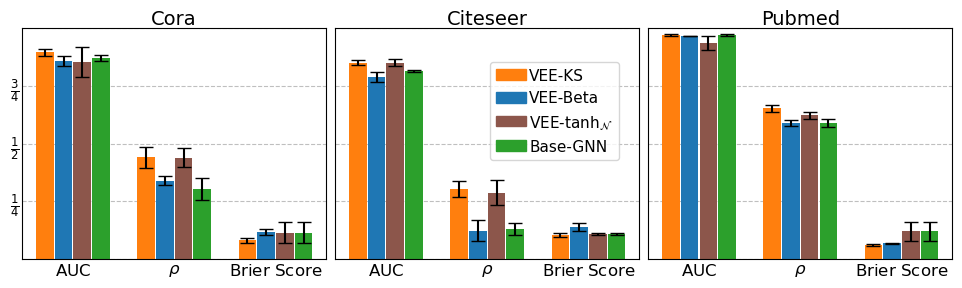

In [11]:
# Create lists to store the data for plotting
auc_means = []
auc_stds = []
pearson_means = []
pearson_stds = []
brier_score_means = []
brier_score_stds = []

# Extract final epoch values for bar plot
for dataset in datasets:
    auc_mean_values = []
    auc_std_values = []
    pearson_mean_values = []
    pearson_std_values = []
    brier_score_mean_values = []
    brier_score_std_values = []
    for model in models:
        auc_mean_values.append(logs[dataset][model]['auc_mean'][-1])  # Last value in the time series
        auc_std_values.append(logs[dataset][model]['auc_std'][-1])    # Last value in the time series
        pearson_mean_values.append(logs[dataset][model]['pearson_mean'][-1])  # Last value in the time series
        pearson_std_values.append(logs[dataset][model]['pearson_std'][-1])    # Last value in the time series
        brier_score_mean_values.append(logs[dataset][model]['brier_score_mean'])
        brier_score_std_values.append(logs[dataset][model]['brier_score_std']) 
    auc_means.append(auc_mean_values)
    auc_stds.append(auc_std_values)
    pearson_means.append(pearson_mean_values)
    pearson_stds.append(pearson_std_values)
    brier_score_means.append(brier_score_mean_values)
    brier_score_stds.append(brier_score_std_values)

# Parameterize the plot
bar_width = 0.08  # Width of the bars
space_between_bars = 0.005  # Space between bars within the same metric
space_between_metrics = 0.12  # Space between different metric groups
space_between_subplots = 0.03  # Space between subplots
vertical_space_between_rows = 0.1  # Space between subplots (vertical)

xlabel_fontsize = 12
xlabel_pad = -25
title_fontsize = 14
title_pad = -5

legend_fontsize = 12

ticks_fontsize = 12

# Create figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 3), gridspec_kw={'wspace': space_between_subplots, 'hspace': vertical_space_between_rows})

# Define common y-ticks and labels
common_yticks = [0, 0.25, 0.5, 0.75, 1.0]
common_yticklabels = [r'', r'$\frac{1}{4}$', r'$\frac{1}{2}$', r'$\frac{3}{4}$', r'']

# Bar plot
for i, dataset in enumerate(datasets):
    x = np.arange(len(models)) * (bar_width + space_between_bars)  # Adjusted positions for each model
    
    auc_positions = x  # AUC bars
    pearson_positions = x + len(models) * (bar_width + space_between_bars) + space_between_metrics  # Pearson bars
    brier_positions = pearson_positions + len(models) * (bar_width + space_between_bars) + space_between_metrics  # Brier Score bars

    # Plot AUC bars with error bars
    for j, model in enumerate(models):
        axs[i].bar(auc_positions[j], auc_means[i][j], bar_width, color=colors[model],
                   yerr=auc_stds[i][j], capsize=5, label=models_to_legend_names[model] if i == 0 else "")

    # Plot Pearson Correlation bars with error bars
    for j, model in enumerate(models):
        axs[i].bar(pearson_positions[j], pearson_means[i][j], bar_width, color=colors[model],
                   yerr=pearson_stds[i][j], capsize=5)

    # Plot Brier Score bars with error bars
    for j, model in enumerate(models):
        axs[i].bar(brier_positions[j], brier_score_means[i][j], bar_width, color=colors[model],
                   yerr=brier_score_stds[i][j], capsize=5)

    # Set x-ticks for each subplot
    axs[i].set_xticks([np.mean(auc_positions), np.mean(pearson_positions), np.mean(brier_positions)])
    #axs[i].set_xticklabels([r'$\mathrm{AUC } \uparrow$', r'$\rho \uparrow$', r'$\mathrm{Brier} \text{ } \mathrm{Score } \downarrow$'], fontsize=xlabel_fontsize) # with up/down arrows
    axs[i].set_xticklabels([r'$\mathrm{AUC}$', r'$\rho$', r'$\mathrm{Brier} \text{ } \mathrm{Score }$'], fontsize=xlabel_fontsize)
    axs[i].set_title(dataset, pad=title_pad, fontsize=title_fontsize)

    # Set y-axis limits and ticks
    axs[i].set_ylim([0, 1.0])
    axs[i].set_yticks(common_yticks)
    axs[i].set_yticklabels(common_yticklabels, fontsize=ticks_fontsize)
    
    if i > 0:
        axs[i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    # Ensure the grid is set for all subplots
    axs[i].set_axisbelow(True)
    axs[i].grid(axis='y', linestyle='--', alpha=0.8)

# Custom legend
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[model]) for model in models]
labels = [models_to_legend_names[model] for model in models]  # Use custom legend names
axs[1].legend(handles, labels, bbox_to_anchor=(0.5, 0.42), handletextpad=0.2, borderaxespad=0.15, ncol=1, fontsize=legend_fontsize-1)

# Adjust ticks and layout
for ax in axs.flatten():
    ax.tick_params(axis='x', length=.01, width=.01)
    ax.tick_params(axis='y', length=.01, width=.01)
    ax.tick_params(axis='both', which='both', pad=2)

# Save and show plot
fig_name = "gnn_bar_all.png"
#plt.savefig(FIGURES_DIR + fig_name, bbox_inches='tight', pad_inches=0.01, dpi=200)
plt.show()


#### Bar Plot with all 2 metrics (AUC, Brier Score)

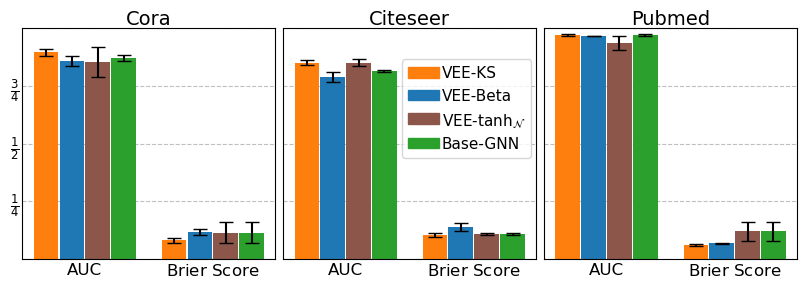

In [12]:
# Initialize lists to store the data for plotting
auc_means = []
auc_stds = []
pearson_means = []
pearson_stds = []
brier_score_means = []
brier_score_stds = []

# Extract final epoch values for bar plot
for dataset in datasets:
    auc_mean_values = []
    auc_std_values = []
    pearson_mean_values = []
    pearson_std_values = []
    brier_score_mean_values = []
    brier_score_std_values = []
    for model in models:
        auc_mean_values.append(logs[dataset][model]['auc_mean'][-1])  # Last value in the time series
        auc_std_values.append(logs[dataset][model]['auc_std'][-1])    # Last value in the time series
        pearson_mean_values.append(logs[dataset][model]['pearson_mean'][-1])  # Last value in the time series
        pearson_std_values.append(logs[dataset][model]['pearson_std'][-1])    # Last value in the time series
        brier_score_mean_values.append(logs[dataset][model]['brier_score_mean'])
        brier_score_std_values.append(logs[dataset][model]['brier_score_std']) 
    auc_means.append(auc_mean_values)
    auc_stds.append(auc_std_values)
    pearson_means.append(pearson_mean_values)
    pearson_stds.append(pearson_std_values)
    brier_score_means.append(brier_score_mean_values)
    brier_score_stds.append(brier_score_std_values)

# Parameterize the plot
bar_width = 0.1  # Width of the bars
space_between_bars = 0.005  # Space between bars within the same metric
space_between_metrics = 0.1  # Space between AUC and Pearson correlation groups
space_between_subplots = 0.03  # Space between subplots
vertical_space_between_rows = 0.1  # Space between subplots (vertical)

xlabel_fontsize = 12
xlabel_pad = -25
title_fontsize = 14
title_pad = -5

legend_fontsize = 12

ticks_fontsize = 12

use_bs = True

# Create the figure with 2 rows and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace': space_between_subplots, 'hspace': vertical_space_between_rows})

# Define common y-ticks and labels
common_yticks = [0, 0.25, 0.5, 0.75, 1.0]
common_yticklabels = [r'', r'$\frac{1}{4}$', r'$\frac{1}{2}$', r'$\frac{3}{4}$', r'']

# First row: Bar plot
for i, dataset in enumerate(datasets):
    x = np.arange(len(models)) * (bar_width + space_between_bars)  # Adjusted positions for each model
    auc_positions = x  # AUC bars
    pearson_positions = x + len(models) * (bar_width + space_between_bars) + space_between_metrics  # Pearson correlation bars

    # Plot AUC bars with error bars
    for j, model in enumerate(models):
        axs[i].bar(auc_positions[j], auc_means[i][j], bar_width, color=colors[model],
                   yerr=auc_stds[i][j], capsize=5, label=models_to_legend_names[model] if i == 0 else "")

    # Plot Pearson Correlation bars with error bars
    for j, model in enumerate(models):
        means, yerr = brier_score_means[i][j] if use_bs else pearson_means[i][j], brier_score_stds[i][j] if use_bs else pearson_stds[i][j]
        axs[i].bar(pearson_positions[j], 
                   means,
                   #brier_score_means[i][j], 
                   bar_width, color=colors[model],
                   yerr=yerr,
                   #yerr=brier_score_stds[i][j], 
                   capsize=5)

    # Set the x-ticks for each subplot
    axs[i].set_xticks([np.mean(auc_positions), np.mean(pearson_positions)])
    axs[i].set_xticklabels(['AUC', r'$\text{Brier Score}$' if use_bs else r'$\rho$'], fontsize=xlabel_fontsize)
    axs[i].set_title(dataset, pad=title_pad, fontsize=title_fontsize)

    # Set y-axis limits and ticks for the first row
    axs[i].set_ylim([0, 1.0])
    axs[i].set_yticks(common_yticks)
    axs[i].set_yticklabels(common_yticklabels, fontsize=ticks_fontsize)
    if i > 0:
        axs[i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    # Ensure the grid is set for all subplots in the first row
    axs[i].set_axisbelow(True)
    axs[i].grid(axis='y', linestyle='--', alpha=0.8)

# Custom legend for the first row
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[model]) for model in models]
labels = [models_to_legend_names[model] for model in models]  # Use custom legend names
axs[1].legend(handles, labels, bbox_to_anchor=(0.46, .43), handletextpad=0.2, borderaxespad=0.15, ncol=1, fontsize=legend_fontsize-1)

for ax in axs.flatten():
    ax.tick_params(axis='x', length=.01, width=.01)
    ax.tick_params(axis='y', length=.01, width=.01)
    ax.tick_params(axis='both', which='both', pad=2)

# Adjust layout and show the plot
fig_name = "gnn_bar_" + 'bs' if use_bs else 'rho' + '.png'
plt.savefig(FIGURES_DIR + fig_name, bbox_inches='tight', pad_inches=0.01, dpi=200)
#plt.savefig(FIGURES_DIR + 'gnn_bar.png', bbox_inches='tight', pad_inches=0.01, dpi=200)
plt.show()


#### Bar plot with 2 metrics and time-series of metric values across training

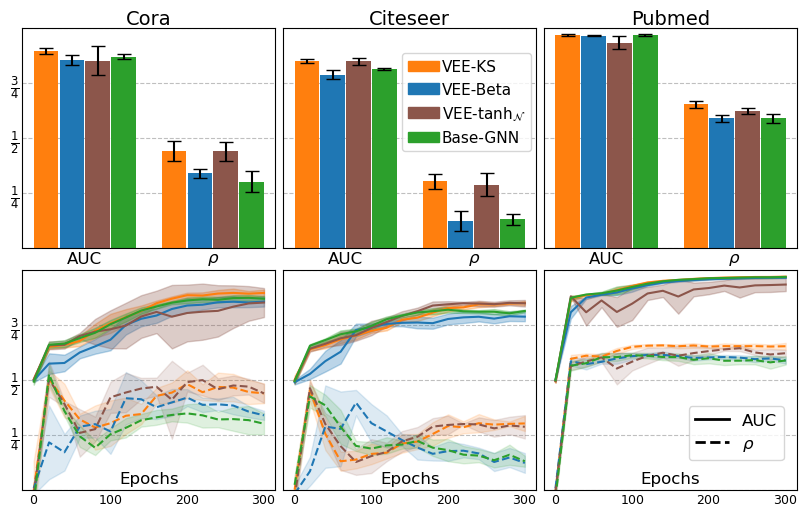

In [13]:
# Initialize lists to store the data for plotting
auc_means = []
auc_stds = []
pearson_means = []
pearson_stds = []

# Extract final epoch values for bar plot
for dataset in datasets:
    auc_mean_values = []
    auc_std_values = []
    pearson_mean_values = []
    pearson_std_values = []
    for model in models:
        auc_mean_values.append(logs[dataset][model]['auc_mean'][-1])  # Last value in the time series
        auc_std_values.append(logs[dataset][model]['auc_std'][-1])    # Last value in the time series
        pearson_mean_values.append(logs[dataset][model]['pearson_mean'][-1])  # Last value in the time series
        pearson_std_values.append(logs[dataset][model]['pearson_std'][-1])    # Last value in the time series
    auc_means.append(auc_mean_values)
    auc_stds.append(auc_std_values)
    pearson_means.append(pearson_mean_values)
    pearson_stds.append(pearson_std_values)

# Parameterize the plot
bar_width = 0.1  # Width of the bars
space_between_bars = 0.005  # Space between bars within the same metric
space_between_metrics = 0.1  # Space between AUC and Pearson correlation groups
space_between_subplots = 0.03  # Space between subplots
vertical_space_between_rows = 0.1  # Space between subplots (vertical)

xlabel_fontsize = 12
xlabel_pad = -25
title_fontsize = 14
title_pad = -5

legend_fontsize = 12

ticks_fontsize = 12

# Create the figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(10, 6), gridspec_kw={'wspace': space_between_subplots, 'hspace': vertical_space_between_rows})

# Define common y-ticks and labels
common_yticks = [0, 0.25, 0.5, 0.75, 1.0]
common_yticklabels = [r'', r'$\frac{1}{4}$', r'$\frac{1}{2}$', r'$\frac{3}{4}$', r'']

# First row: Bar plot
for i, dataset in enumerate(datasets):
    x = np.arange(len(models)) * (bar_width + space_between_bars)  # Adjusted positions for each model
    auc_positions = x  # AUC bars
    pearson_positions = x + len(models) * (bar_width + space_between_bars) + space_between_metrics  # Pearson correlation bars

    # Plot AUC bars with error bars
    for j, model in enumerate(models):
        axs[0, i].bar(auc_positions[j], auc_means[i][j], bar_width, color=colors[model],
                      yerr=auc_stds[i][j], capsize=5, label=models_to_legend_names[model] if i == 0 else "")

    # Plot Pearson Correlation bars with error bars
    for j, model in enumerate(models):
        axs[0, i].bar(pearson_positions[j], pearson_means[i][j], bar_width, color=colors[model],
                      yerr=pearson_stds[i][j], capsize=5)

    # Set the x-ticks for each subplot
    axs[0, i].set_xticks([np.mean(auc_positions), np.mean(pearson_positions)])
    axs[0, i].set_xticklabels(['AUC', r'$\rho$'], fontsize=xlabel_fontsize)
    axs[0, i].set_title(dataset, pad=title_pad, fontsize=title_fontsize)

    # Set y-axis limits and ticks for the first row
    axs[0, i].set_ylim([0, 1.0])
    axs[0, i].set_yticks(common_yticks)
    axs[0, i].set_yticklabels(common_yticklabels, fontsize=ticks_fontsize)
    if i > 0:
        axs[0, i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    # Ensure the grid is set for all subplots in the first row
    axs[0, i].set_axisbelow(True)
    axs[0, i].grid(axis='y', linestyle='--', alpha=0.8)

# Second row: Time series plot for both AUC and Pearson correlation
for i, dataset in enumerate(datasets):
    for model in models:
        auc_mean = logs[dataset][model]['auc_mean']
        auc_std = logs[dataset][model]['auc_std']
        pearson_mean = logs[dataset][model]['pearson_mean']
        pearson_std = logs[dataset][model]['pearson_std']
        epochs = logs[dataset][model]['epochs'][0]  # Use the epochs stored in the logs

        # Plot AUC
        axs[1, i].plot(epochs, auc_mean, label=f"{models_to_legend_names[model]} AUC", color=colors[model], linestyle='-')
        axs[1, i].fill_between(epochs, auc_mean - auc_std, auc_mean + auc_std, color=colors[model], alpha=0.3)

        # Plot Pearson correlation
        axs[1, i].plot(epochs, pearson_mean, label=f"{models_to_legend_names[model]} Pearson", color=colors[model], linestyle='--')
        axs[1, i].fill_between(epochs, pearson_mean - pearson_std, pearson_mean + pearson_std, color=colors[model], alpha=0.15)
    
    # Set y-axis limits and ticks for the second row to match the first row
    axs[1, i].set_ylim([0, 1.0])
    axs[1, i].set_yticks(common_yticks)
    axs[1, i].set_yticklabels(common_yticklabels, fontsize=ticks_fontsize)
    if i > 0:
        axs[1, i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    # Ensure that x-ticks only include 100, 200, and 300
    epoch_ticks = [0, 100, 200, 300]
    epoch_ticklabels = [r'$0$', r'$100$', r'$200$', r'$300$']
    axs[1, i].set_xticks(epoch_ticks)
    axs[1, i].set_xticklabels(epoch_ticklabels, fontsize=ticks_fontsize-3)

    # Set grid for the second row
    axs[1, i].set_axisbelow(True)
    axs[1, i].grid(axis='y', linestyle='--', alpha=0.8)

# Add custom legend to axs[1, 2]
legend_elements = [
    plt.Line2D([0], [0], color='black', lw=2, linestyle='-', label='AUC'),
    plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label=r'$\rho$')
]
axs[1, 2].legend(handles=legend_elements, bbox_to_anchor=(0.98, 0.1), loc='lower right', fontsize=legend_fontsize)


# Set common x-label for the second row
for ax in axs[1, :]:
    ax.set_xlabel('Epochs', fontsize=xlabel_fontsize, labelpad=xlabel_pad)

# Custom legend for the first row
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[model]) for model in models]
labels = [models_to_legend_names[model] for model in models]  # Use custom legend names
axs[0, 1].legend(handles, labels, bbox_to_anchor=(0.46, .43), handletextpad=0.2, borderaxespad=0.15, ncol=1, fontsize=legend_fontsize-1)

for ax in axs.flatten():
    ax.tick_params(axis='x', length=.01, width=.01)
    ax.tick_params(axis='y', length=.01, width=.01)
    ax.tick_params(axis='both', which='both', pad=2)

# Adjust layout and show the plot
#plt.savefig(FIGURES_DIR + 'gnn_bar_and_time_series.png', bbox_inches='tight', pad_inches=0.01, dpi=200)
plt.show()
